# EDA - stage 2

In [882]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sb
import warnings
import missingno as msno
from statsmodels.imputation import mice
from sklearn.preprocessing import OneHotEncoder

# !pip install missingno
# Ignore warnings
warnings.filterwarnings('ignore')

In [883]:
# Load the data
df2 = pd.read_pickle('df_after_eda1.pkl')

In [884]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51372 entries, 6 to 168636
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   number_of_seasons   51372 non-null  int64   
 1   number_of_episodes  51372 non-null  int64   
 2   vote_count          51372 non-null  int64   
 3   vote_average        51372 non-null  float64 
 4   adult               51372 non-null  category
 5   first_air_date      51372 non-null  string  
 6   last_air_date       50938 non-null  string  
 7   popularity          51372 non-null  float64 
 8   type                51372 non-null  string  
 9   status              51372 non-null  string  
 10  genres              34485 non-null  string  
 11  languages           36954 non-null  string  
 12  networks            33041 non-null  string  
 13  origin_country      44490 non-null  string  
 14  episode_run_time    51372 non-null  int64   
dtypes: category(1), float64(2), int64(4), st

# Outlires detection

Checking number of Nulls before handling outliers (numeric features)

In [887]:
df_numeric = df2[["number_of_seasons", "number_of_episodes", "vote_count", "vote_average", "popularity", "episode_run_time"]]
df_numeric.isnull().sum()

number_of_seasons     0
number_of_episodes    0
vote_count            0
vote_average          0
popularity            0
episode_run_time      0
dtype: int64

No missing data in the numeric features (before outliers detection)

## Box Plots

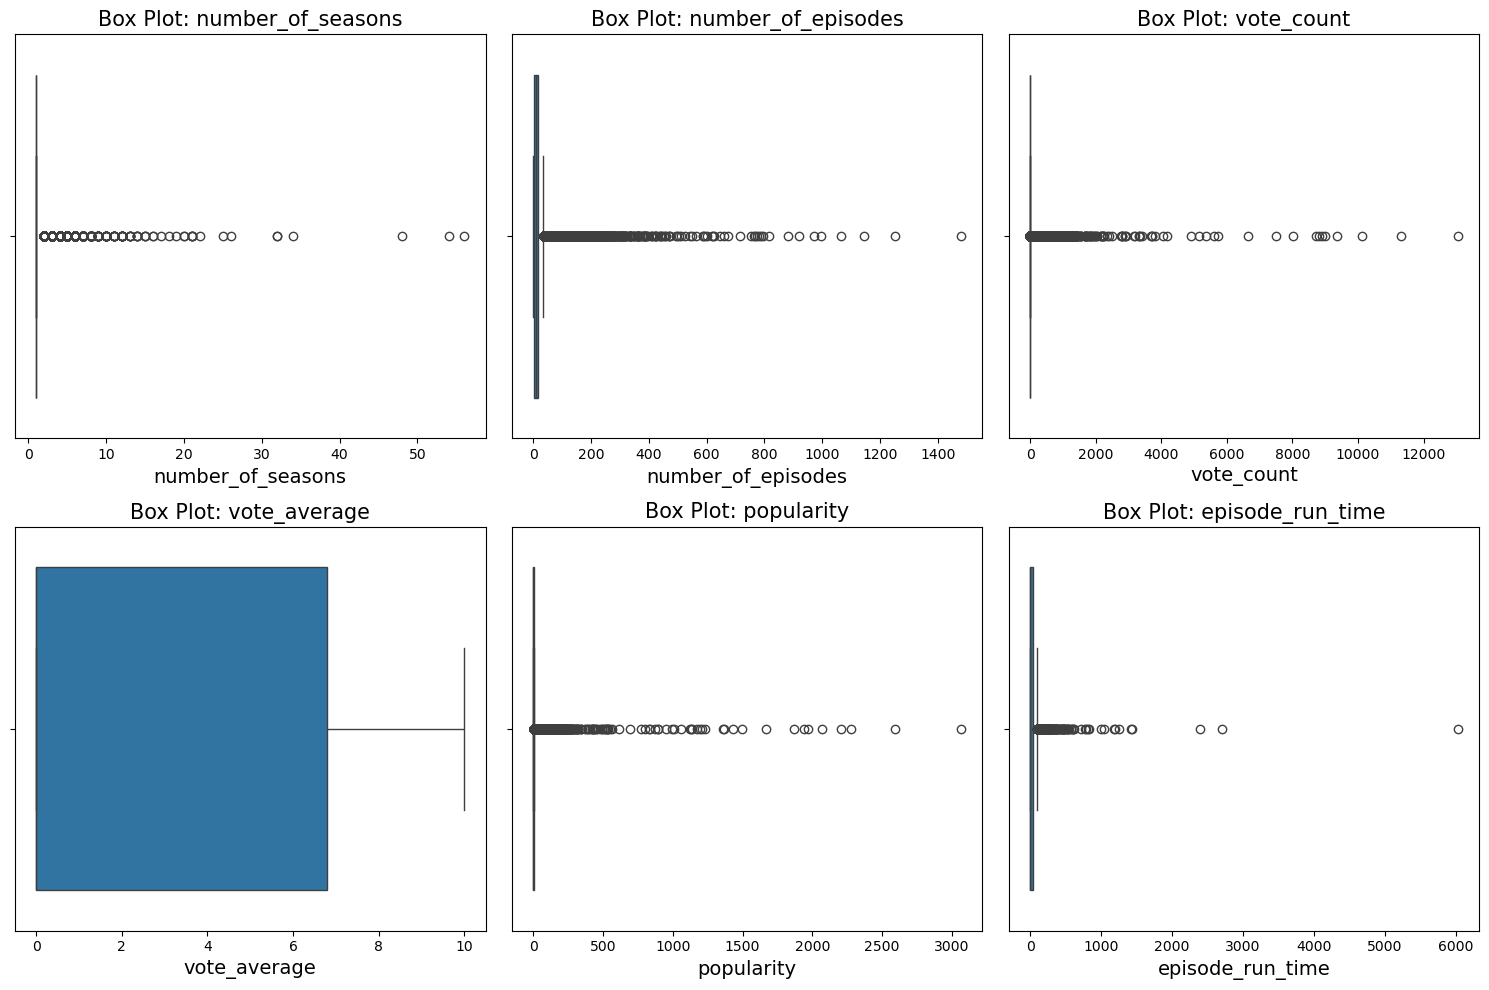

In [890]:
# Function to generate boxplots for each column
def outliers_boxplot(df, cols_per_row=3):
    num_cols = len(df.columns)
    rows = (num_cols // cols_per_row) + (num_cols % cols_per_row > 0)

    fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 5, rows * 5))
    axes = axes.flatten()  # Flatten for easy iteration

    for i, col in enumerate(df.columns):
        sb.boxplot(data=df, x=col, ax=axes[i])
        axes[i].set_title(f'Box Plot: {col}', fontsize=15)
        axes[i].set_xlabel(col, fontsize=14)

    # Hide extra unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Calling the function
outliers_boxplot(df_numeric)

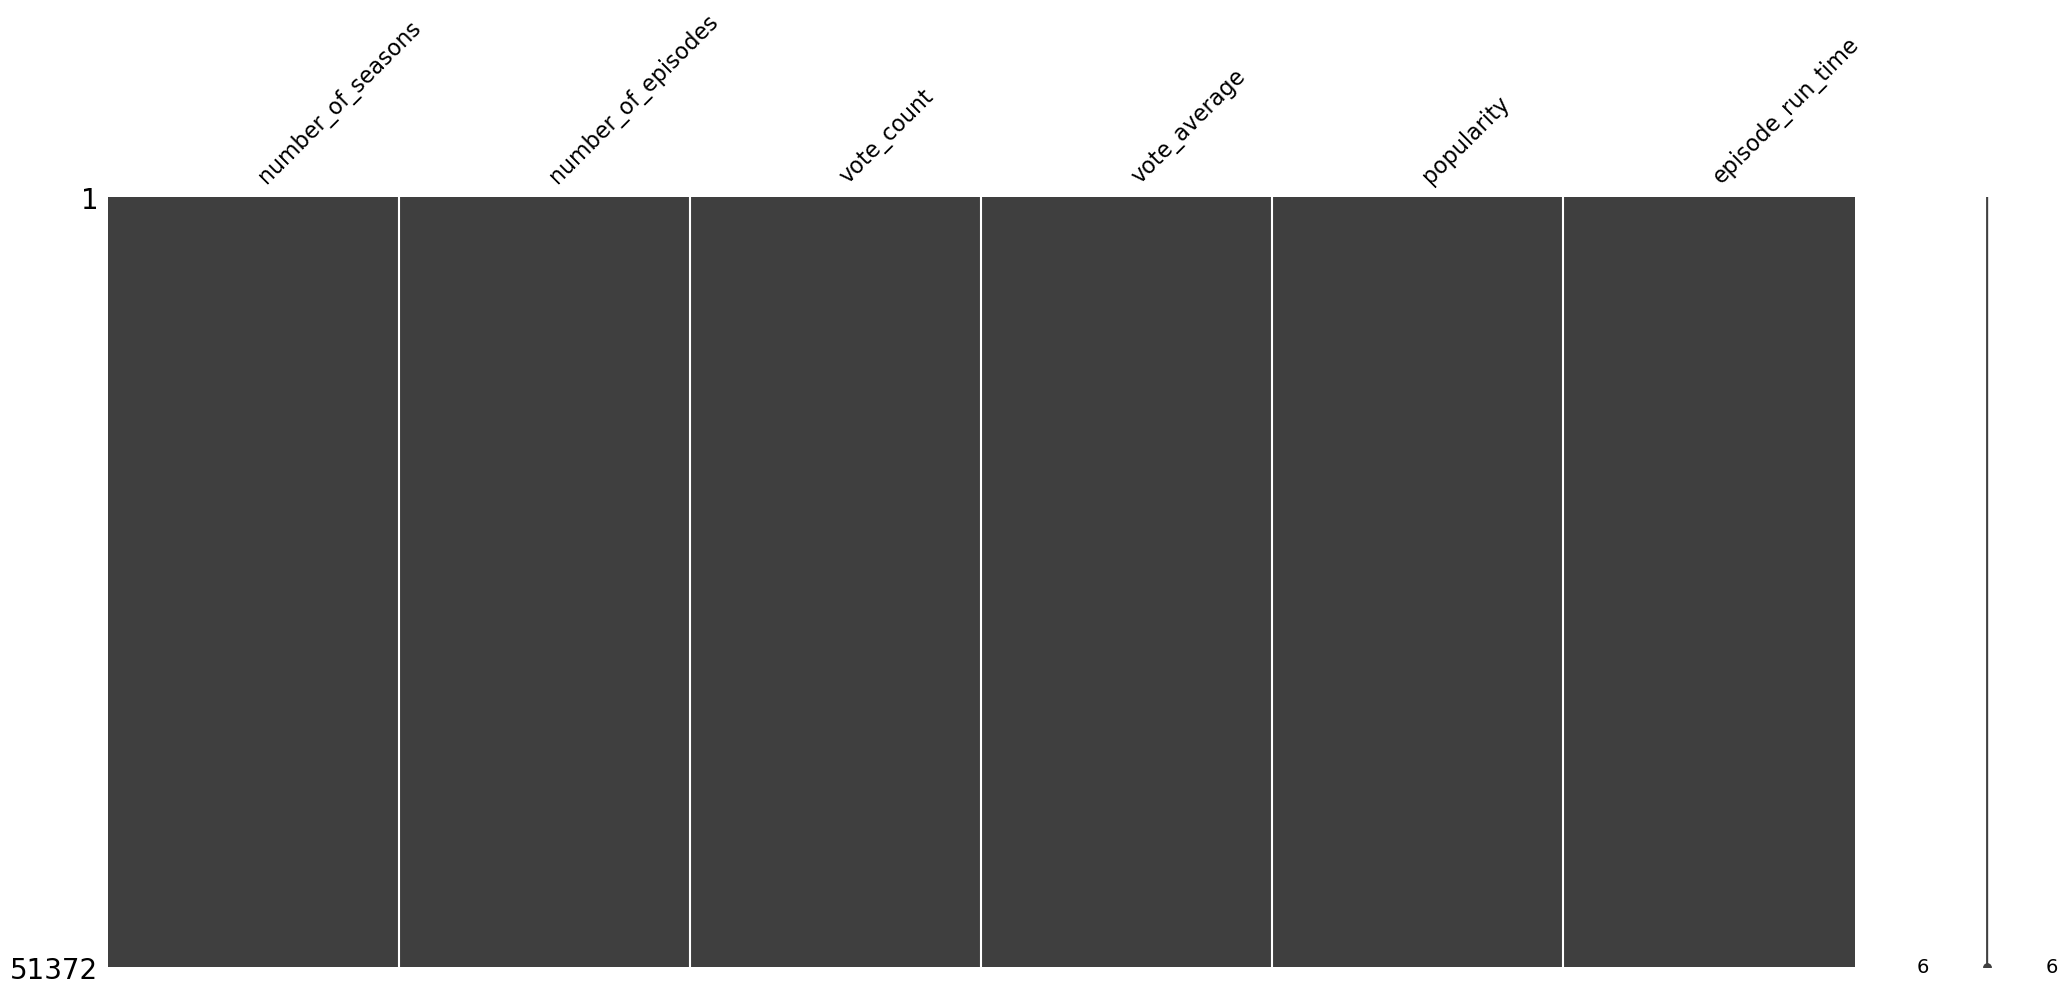

In [891]:
# Visualizing missing data before IQR processing (excluding 'popularity') - as mentioned above we are expecting for no nulls
msno.matrix(df_numeric)
plt.show()  

## IQR

In [893]:
from scipy.stats import ks_2samp, norm
from tabulate import tabulate # Table display

df_numeric = df2[['number_of_seasons', 'number_of_episodes', 'vote_count', 'vote_average', 'episode_run_time']]  # Excluding 'popularity'
popularity = df2['popularity']  # Explicitly reference 'popularity'

# Function to detect outliers using IQR
def outliers_df(df):
    total_outliers = pd.DataFrame(columns=['Outlier count', 'Percent'])
    for col in df.select_dtypes(include=[np.number]):  # Ensure processing numeric columns only
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        upper_limit = Q3 + 1.5 * IQR
        lower_limit = Q1 - 1.5 * IQR
        # Filtering rows that are outliers in either direction
        temp_outliers = df[(df[col] > upper_limit) | (df[col] < lower_limit)]
        num_outliers = len(temp_outliers)
        total_outliers.loc[col] = [num_outliers, num_outliers / len(df) * 100]

    return total_outliers[total_outliers['Percent'] > 0]  # Keeping only columns with outliers

# Detecting outliers in df_numeric
outliers_df_result = outliers_df(df_numeric)
outliers_df_result_sorted = outliers_df_result.sort_values('Percent', ascending=False)

# Function for correlation comparison using Fisher method
def cocor(x1, y1, x2, y2):
    xy1 = x1.corr(y1, method='spearman')
    xy2 = x2.corr(y2, method='spearman')
    n1 = len(x1)
    n2 = len(x2)
    xy_z = 0.5 * np.log((1 + xy1) / (1 - xy1))
    ab_z = 0.5 * np.log((1 + xy2) / (1 - xy2))
    if n2 is None:
        n2 = n1
    se_diff_r = np.sqrt(1 / (n1 - 3) + 1 / (n2 - 3))
    diff = xy_z - ab_z
    z = abs(diff / se_diff_r)
    p = (1 - norm.cdf(z)) * 2
    return z, p

# Creating a DataFrame to store correlation and distribution changes
out_df = pd.DataFrame(columns=['Feature', 'Outliers Count', 'Distribution Changed', 'Correlation Changed'])

rows = []  # Collecting rows here to avoid repeatedly modifying the DataFrame
for col in df_numeric.select_dtypes(include=[np.number]):  # Iterate only over numeric columns
    if col != 'popularity':  # Ensuring we skip the 'popularity' column
        out = df_numeric[col]  # Data with outliers
        non = df_numeric[col].loc[df_outliers[col] == 0]  # Data without outliers
        
        # Calculating correlation p-value with 'popularity'
        p, pvalue = cocor(out, popularity, non, popularity)  # Using 'popularity' as the target
        cor_change = '+' if pvalue < 0.05 else '-'
        
        # Counting outliers
        mv = df_outliers[col].sum()
        
        # KS test p-value to check distribution change
        pval = ks_2samp(out, non)[1]
        dist_change = '+' if pval < 0.05 else '-'
        
        # Appending the data as a dictionary
        rows.append({
            'Feature': col,
            'Outliers Count': mv,
            'Distribution Changed': dist_change,
            'Correlation Changed': cor_change
        })

# Creating out_df from rows
out_df = pd.DataFrame(rows)

# Marking columns to be dropped based on correlation and distribution changes
out_df['Drop'] = 'yes'
out_df.loc[(out_df['Distribution Changed'] == '+') & (out_df['Correlation Changed'] == '+'), 'Drop'] = 'no'

# Displaying the results using tabulate for a cleaner output
print("Outlier and Feature Evaluation Results:")
print(tabulate(out_df, headers='keys', tablefmt='pretty', showindex=False))

# Getting the relevant features for further processing
relevant_columns = out_df.loc[out_df['Drop'] == 'yes']
relevant_columns_features = out_df.loc[out_df['Drop'] == 'yes']['Feature']

# Displaying features marked for removal
print("\nFeatures to remove outliers:", relevant_columns_features.tolist())

# Capping Outliers by replacing them with NaN
def capping(df, relevant_columns_features):
    temp = df.copy()
    for col in relevant_columns_features:
        Q1 = temp[col].quantile(0.25)
        Q3 = temp[col].quantile(0.75)
        upper_limit = Q3 + 1.5 * (Q3 - Q1)
        lower_limit = Q3 - 1.5 * (Q3 - Q1)
        # Replace outliers with NaN instead of 0
        temp[col] = np.where(temp[col] > upper_limit, np.nan, np.where(temp[col] < lower_limit, np.nan, temp[col]))
    return temp

# Applying capping to the data
df_numeric_no_outliers = capping(df_numeric, relevant_columns_features)

# Directly update df2 with the cleaned df_numeric_no_outliers (with outliers capped)
df2[df_numeric_no_outliers.columns] = df_numeric_no_outliers  # Update only the numeric columns in df2

# Displaying the final modified df2
df2.head()

Outlier and Feature Evaluation Results:
+--------------------+----------------+----------------------+---------------------+------+
|      Feature       | Outliers Count | Distribution Changed | Correlation Changed | Drop |
+--------------------+----------------+----------------------+---------------------+------+
| number_of_seasons  |      8279      |          +           |          -          | yes  |
| number_of_episodes |      8918      |          +           |          +          |  no  |
|     vote_count     |     12648      |          +           |          +          |  no  |
|    vote_average    |       0        |          -           |          -          | yes  |
|  episode_run_time  |      2457      |          +           |          -          | yes  |
+--------------------+----------------+----------------------+---------------------+------+

Features to remove outliers: ['number_of_seasons', 'vote_average', 'episode_run_time']


,number_of_seasons,number_of_episodes,vote_count,vote_average,adult,first_air_date,last_air_date,popularity,type,status,genres,languages,networks,origin_country,episode_run_time
6,NaN,9,13053,7.831,False,2021-09-17,2021-09-17,115.587,Scripted,Returning Series,"['Other', 'Other', 'drama']","['en', 'ko', 'Other']",['netflix'],['kr'],0.0
9,1.0,9,11308,8.300,False,2021-01-15,2021-03-05,62.893,Miniseries,Ended,"['Other', 'Other', 'drama']",['en'],['Other'],['us'],0.0
12,NaN,12,10136,8.200,False,2021-06-09,2021-07-14,276.759,Scripted,Returning Series,"['drama', 'Other']",['en'],['Other'],['us'],52.0
14,NaN,24,9353,8.500,False,2019-11-12,2023-04-19,154.480,Scripted,Returning Series,"['Other', 'Other', 'drama']",['en'],['Other'],['us'],0.0
16,NaN,16,9008,8.353,False,2019-06-16,2022-02-27,197.456,Scripted,Returning Series,"['drama', 'Other']",['en'],['Other'],['us'],60.0


In [894]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51372 entries, 6 to 168636
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   number_of_seasons   43093 non-null  float64 
 1   number_of_episodes  51372 non-null  int64   
 2   vote_count          51372 non-null  int64   
 3   vote_average        51372 non-null  float64 
 4   adult               51372 non-null  category
 5   first_air_date      51372 non-null  string  
 6   last_air_date       50938 non-null  string  
 7   popularity          51372 non-null  float64 
 8   type                51372 non-null  string  
 9   status              51372 non-null  string  
 10  genres              34485 non-null  string  
 11  languages           36954 non-null  string  
 12  networks            33041 non-null  string  
 13  origin_country      44490 non-null  string  
 14  episode_run_time    50578 non-null  float64 
dtypes: category(1), float64(4), int64(2), st

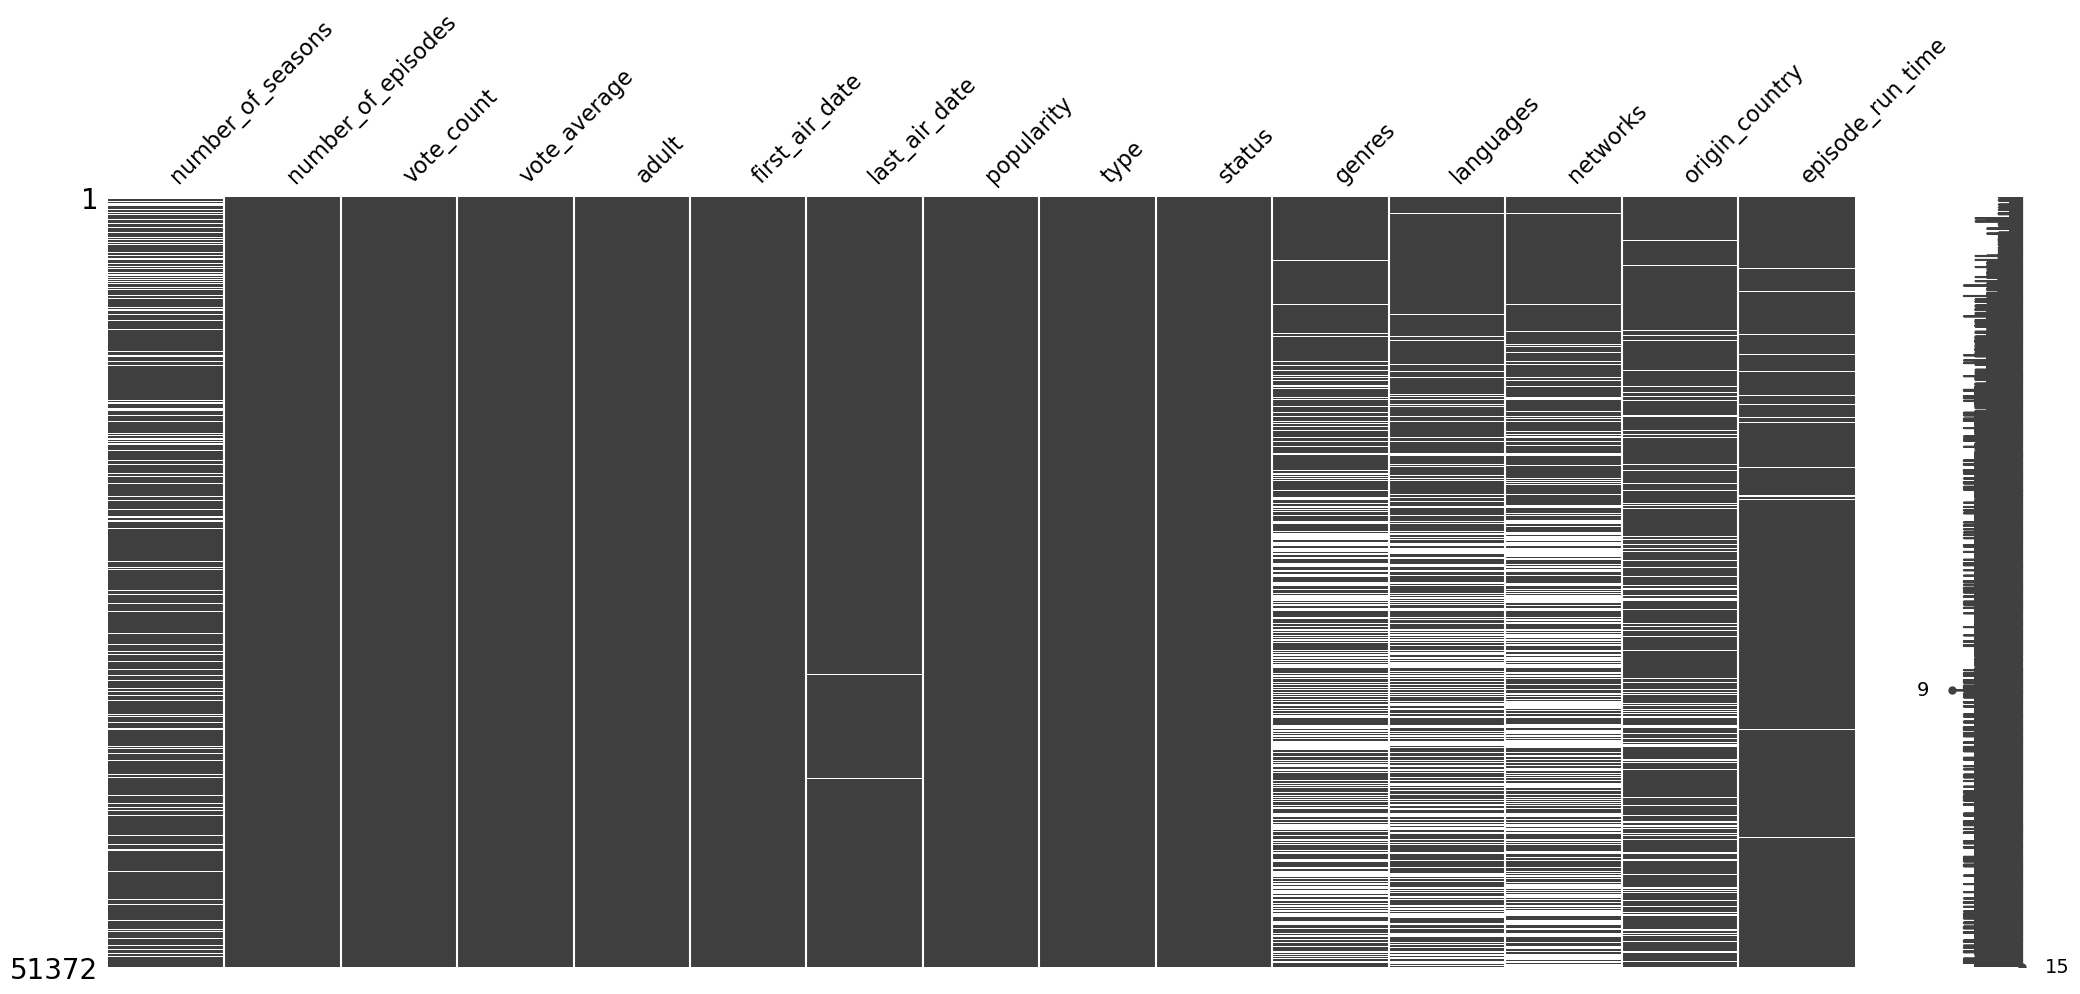

In [895]:
# Visualizing missing data (all features) after IQR processing which was done for numeric features
msno.matrix(df2)
plt.show() 

# Missing data

## Date - "manual" function

last_air_date

In [899]:
df2['last_air_date'].isna().sum()

434

In [900]:
# Defining the mapping for statuses
complete_statuses = ['complete', 'canceled', 'ended', 'pilot']
in_production_statuses = ['in production', 'planned', 'returning series']

# Function to fill 'last_air_date' based on 'status'
def fill_last_air_date(row):
    # Checking the status (case-insensitive) and fill 'last_air_date' accordingly
    status = row['status'].lower() if isinstance(row['status'], str) else ''
    
    if status in complete_statuses:
        return row['first_air_date']  # Use the first_air_date for these statuses
    elif status in in_production_statuses:
        return pd.to_datetime('2025-03-15')  # Use the given date for these statuses
    else:
        return 'other'  # If status doesn't match any, return 'other'

# Applying the function to fill missing 'last_air_date'
df2['last_air_date'] = df2.apply(fill_last_air_date, axis=1)

# Converting 'last_air_date' and 'first_air_date' to datetime
df2['last_air_date'] = pd.to_datetime(df2['last_air_date'], errors='coerce')
df2['first_air_date'] = pd.to_datetime(df2['first_air_date'], errors='coerce')

# Checking the result
print(df2[['last_air_date', 'first_air_date']].head())
df2['last_air_date'].isnull().sum()

   last_air_date first_air_date
6     2025-03-15     2021-09-17
9     2021-01-15     2021-01-15
12    2025-03-15     2021-06-09
14    2025-03-15     2019-11-12
16    2025-03-15     2019-06-16


0

## Categorical (genres, networks, languages, origin_country) - KNN & random min-max

In [902]:
import random
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# List of categorical columns
categorical_columns = ['genres', 'networks', 'languages', 'origin_country']

# Replacing 'nan' strings and empty strings with actual NaN
def clean_na(df):
    df.replace('nan', np.nan, inplace=True)  # Replace 'nan' string with NaN
    df.replace('', np.nan, inplace=True)  # Replace empty strings with NaN
    return df

# Applying the cleaning function to all categorical columns in df2
df2[categorical_columns] = df2[categorical_columns].apply(clean_na)

# Converting categorical values to numerical using Label Encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df2[col] = df2[col].fillna('missing')  # Temporarily replace NaN with 'missing'
    df2[col] = le.fit_transform(df2[col].astype(str))  # Convert categories to numbers
    label_encoders[col] = le  # Store encoder for inverse transformation

# Applying KNN imputation
imputer = KNNImputer(n_neighbors=5)
df2[categorical_columns] = imputer.fit_transform(df2[categorical_columns])

# Converting KNN-imputed values to integers (and round)
df2[categorical_columns] = df2[categorical_columns].round().astype(int)  # Ensure integer values

# Converting back to original categorical values **only for valid (non-NaN)**
for col in categorical_columns:
    valid_indices = df2[col].notna()  # Get indices that are not NaN
    df2.loc[valid_indices, col] = label_encoders[col].inverse_transform(df2.loc[valid_indices, col].astype(int))

# Replacing 'missing' string values with actual NaN values
df2[categorical_columns] = df2[categorical_columns].replace('missing', np.nan)

# Handling "missing" values that KNN didn't fix using the Min/Max approach
def fill_missing_with_min_max(df, col):
    # Getting the valid values of the column (non-NaN)
    valid_values = df[col].dropna().unique()
    
    # If there are no valid values (i.e., the column is entirely NaN), skip this column
    if len(valid_values) == 0:
        return df
    
    # Finding the min and max value lexicographically
    min_val = min(valid_values, key=lambda x: len(str(x)))  # Smallest value based on string length
    max_val = max(valid_values, key=lambda x: len(str(x)))  # Largest value based on string length
    
    # Replacing NaNs with random choice between min_val and max_val
    df[col] = df[col].apply(lambda x: random.choice([min_val, max_val]) if pd.isna(x) else x)
    return df

# Applying the Min/Max filling to columns with "missing" values
for col in categorical_columns:
    df2 = fill_missing_with_min_max(df2, col)

# Final check for missing values after imputation and filling
print("\nMissing values after imputation and min/max filling:")
print(df2[categorical_columns].isnull().sum())

# Showing the final DataFrame after processing
print("\nFinal DataFrame after processing:")
df2.head()


Missing values after imputation and min/max filling:
genres            0
networks          0
languages         0
origin_country    0
dtype: int64

Final DataFrame after processing:


,number_of_seasons,number_of_episodes,vote_count,vote_average,adult,first_air_date,last_air_date,popularity,type,status,genres,languages,networks,origin_country,episode_run_time
6,NaN,9,13053,7.831,False,2021-09-17,2025-03-15,115.587,Scripted,Returning Series,"['Other', 'Other', 'drama']","['en', 'ko', 'Other']",['netflix'],['kr'],0.0
9,1.0,9,11308,8.300,False,2021-01-15,2021-01-15,62.893,Miniseries,Ended,"['Other', 'Other', 'drama']",['en'],['Other'],['us'],0.0
12,NaN,12,10136,8.200,False,2021-06-09,2025-03-15,276.759,Scripted,Returning Series,"['drama', 'Other']",['en'],['Other'],['us'],52.0
14,NaN,24,9353,8.500,False,2019-11-12,2025-03-15,154.480,Scripted,Returning Series,"['Other', 'Other', 'drama']",['en'],['Other'],['us'],0.0
16,NaN,16,9008,8.353,False,2019-06-16,2025-03-15,197.456,Scripted,Returning Series,"['drama', 'Other']",['en'],['Other'],['us'],60.0


In [903]:
df2.head()
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51372 entries, 6 to 168636
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   number_of_seasons   43093 non-null  float64       
 1   number_of_episodes  51372 non-null  int64         
 2   vote_count          51372 non-null  int64         
 3   vote_average        51372 non-null  float64       
 4   adult               51372 non-null  category      
 5   first_air_date      51372 non-null  datetime64[ns]
 6   last_air_date       51372 non-null  datetime64[ns]
 7   popularity          51372 non-null  float64       
 8   type                51372 non-null  string        
 9   status              51372 non-null  string        
 10  genres              51372 non-null  object        
 11  languages           51372 non-null  object        
 12  networks            51372 non-null  object        
 13  origin_country      51372 non-null  object        

Missing data for numeric after outliers detection

## Mice (continuous)

In [906]:
from sklearn.impute import SimpleImputer

# Inspecting missing values in the relevant columns before imputation
print("Missing values before imputation (numeric columns):")
missing_before = df2[['number_of_seasons', 'number_of_episodes', 'vote_count', 
                     'vote_average', 'episode_run_time', 'popularity']].isna().sum()
print(missing_before)

# Ensuring columns to impute are of the correct type (numeric)
# We will select only numeric columns to impute, excluding any other non-numeric data types (anyway no nulls in popularity so we can add it also)

numeric_columns = ['number_of_seasons', 'number_of_episodes', 'vote_count', 
                   'vote_average', 'episode_run_time', 'popularity']

# Applying SimpleImputer to impute missing values using the mean strategy
imputer = SimpleImputer(strategy='mean')

# Imputing the numeric columns directly in df2
df2[numeric_columns] = imputer.fit_transform(df2[numeric_columns])

# Checking for missing values after imputation
print("\nMissing values after imputation (numeric columns):")
missing_after_imputation = df2[['number_of_seasons', 'number_of_episodes', 'vote_count', 
                                'vote_average', 'episode_run_time', 'popularity']].isna().sum()
print(missing_after_imputation)

# Verifing if any missing values remain in the entire DataFrame
print("\nMissing values in the entire df2 after imputation:")
missing_in_entire_df = df2.isna().sum()
print(missing_in_entire_df)

Missing values before imputation (numeric columns):
number_of_seasons     8279
number_of_episodes       0
vote_count               0
vote_average             0
episode_run_time       794
popularity               0
dtype: int64

Missing values after imputation (numeric columns):
number_of_seasons     0
number_of_episodes    0
vote_count            0
vote_average          0
episode_run_time      0
popularity            0
dtype: int64

Missing values in the entire df2 after imputation:
number_of_seasons     0
number_of_episodes    0
vote_count            0
vote_average          0
adult                 0
first_air_date        0
last_air_date         0
popularity            0
type                  0
status                0
genres                0
languages             0
networks              0
origin_country        0
episode_run_time      0
dtype: int64


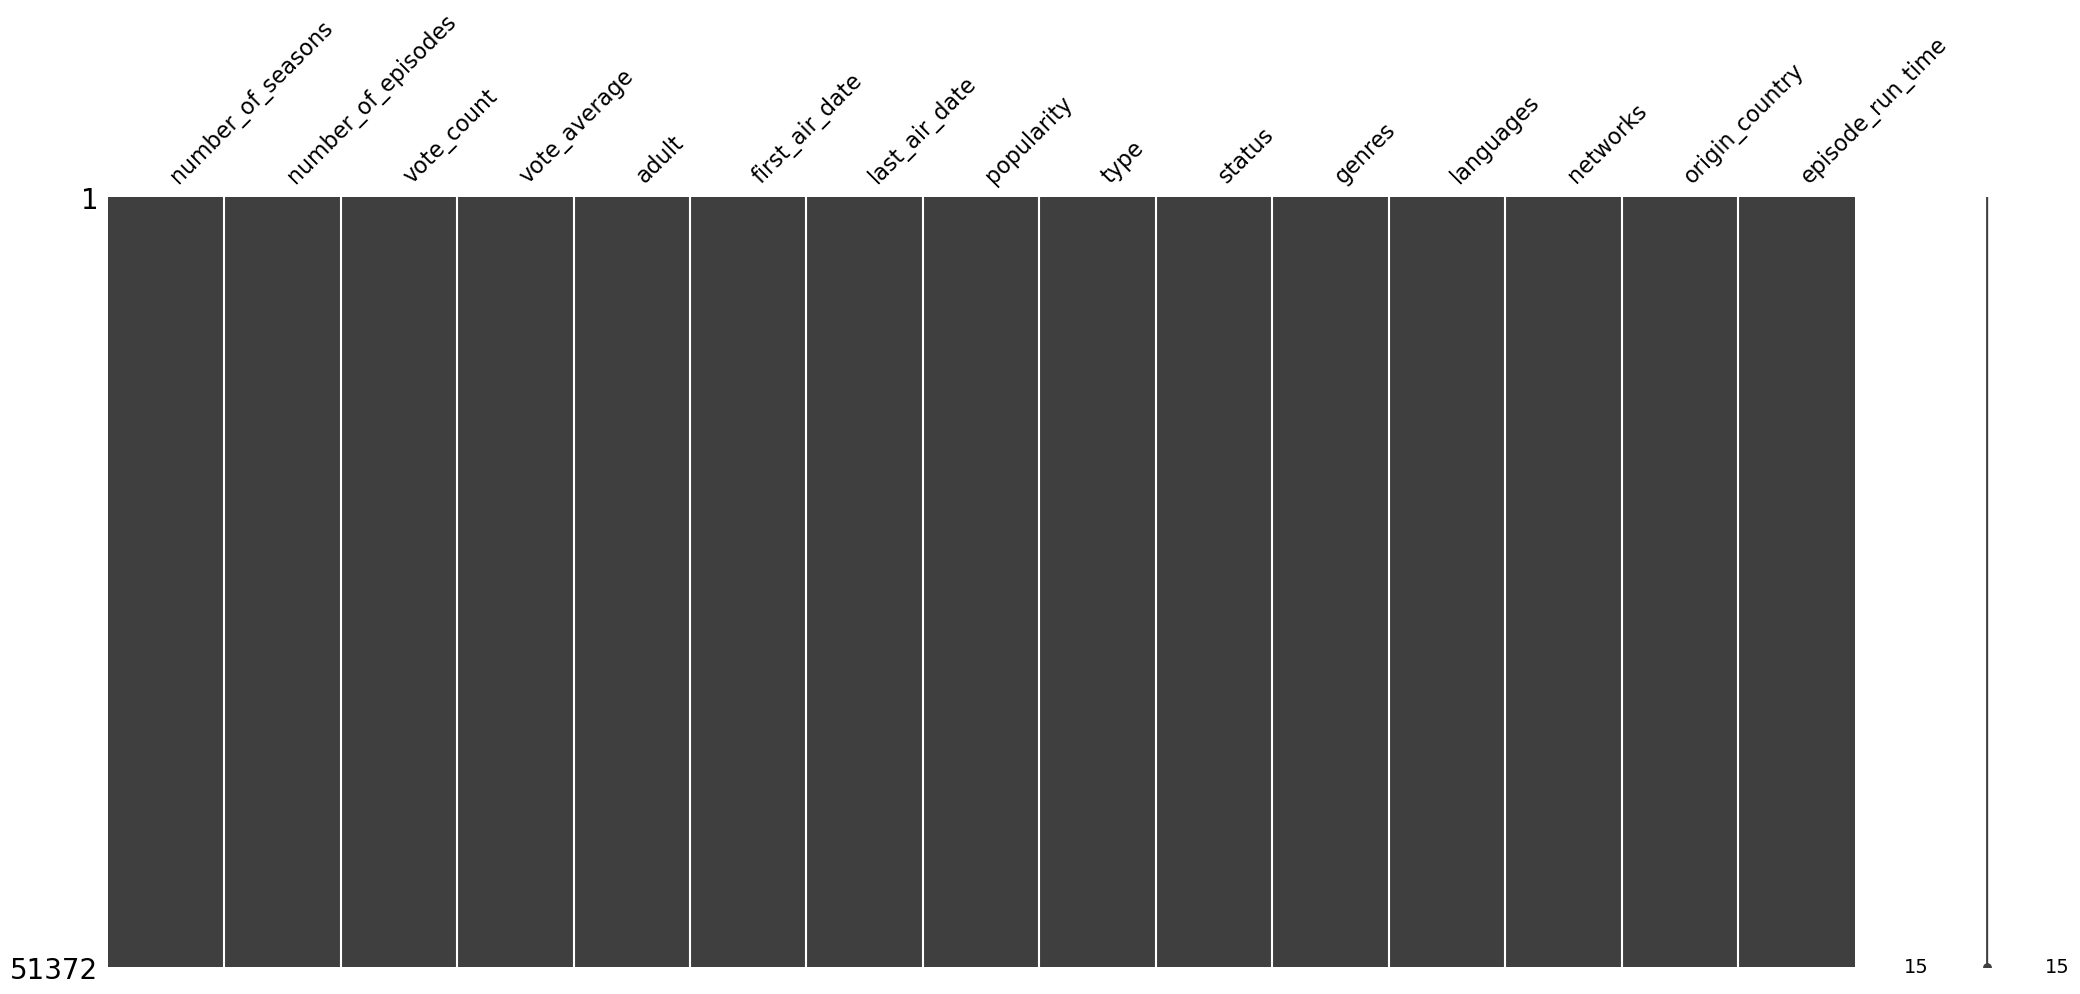

In [907]:
# Visualizing missing data using missingno (final stage - expected to no missing)
msno.matrix(df2)
plt.show()

In [908]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51372 entries, 6 to 168636
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   number_of_seasons   51372 non-null  float64       
 1   number_of_episodes  51372 non-null  float64       
 2   vote_count          51372 non-null  float64       
 3   vote_average        51372 non-null  float64       
 4   adult               51372 non-null  category      
 5   first_air_date      51372 non-null  datetime64[ns]
 6   last_air_date       51372 non-null  datetime64[ns]
 7   popularity          51372 non-null  float64       
 8   type                51372 non-null  string        
 9   status              51372 non-null  string        
 10  genres              51372 non-null  object        
 11  languages           51372 non-null  object        
 12  networks            51372 non-null  object        
 13  origin_country      51372 non-null  object        

Pickle file

In [910]:
df2.to_pickle('df_after_eda2.pkl')